# Milestone 1: Dataset Exploration and Model Setup

This notebook demonstrates:
1. Loading and analyzing the yahma/alpaca-cleaned dataset
2. Setting up the Qwen/Qwen3-0.6B-Base model
3. Data preprocessing for fine-tuning

## 1. Install Required Libraries

In [1]:
!pip install -q torch transformers datasets accelerate

## 2. Import Libraries

In [2]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB


## 3. Dataset Analysis

### 3.1 Load the yahma/alpaca-cleaned Dataset

In [3]:
print("Loading yahma/alpaca-cleaned dataset...")
dataset = load_dataset("yahma/alpaca-cleaned")
print(f"\nDataset structure: {dataset}")
print(f"\nNumber of examples in train split: {len(dataset['train'])}")

Loading yahma/alpaca-cleaned dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

alpaca_data_cleaned.json:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]


Dataset structure: DatasetDict({
    train: Dataset({
        features: ['output', 'input', 'instruction'],
        num_rows: 51760
    })
})

Number of examples in train split: 51760


### 3.2 Examine Dataset Structure

In [4]:
# Display the first example to understand the structure
print("First example from the dataset:")
print(dataset['train'][0])
print(f"\nDataset features: {dataset['train'].features}")

First example from the dataset:
{'output': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.', 'input': '', 'instruction': 'Give three tips for staying healthy.'}

Dataset features: {'output': Value('string'), 'input': Value('string'), 'instruction': Value('string')}


### 3.3 Display 10 Sample Examples

In [5]:
print("=" * 80)
print("10 Sample Examples from the Dataset")
print("=" * 80)

for i in range(10):
    example = dataset['train'][i]
    print(f"\n--- Example {i+1} ---")
    print(f"Instruction: {example['instruction']}")
    print(f"Input: {example['input']}")
    print(f"Output: {example['output']}")
    print("-" * 80)

10 Sample Examples from the Dataset

--- Example 1 ---
Instruction: Give three tips for staying healthy.
Input: 
Output: 1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.

2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.

3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.
--------------------------------------------------------------------------------

--- Example 2 ---
Instruction: What are th

### 3.4 Statistical Analysis of Instruction and Response Lengths

In [6]:
# Calculate lengths for all examples
instruction_lengths = []
input_lengths = []
output_lengths = []

for example in dataset['train']:
    instruction_lengths.append(len(example['instruction'].split()))
    input_lengths.append(len(example['input'].split()))
    output_lengths.append(len(example['output'].split()))

# Calculate statistics
def print_statistics(name, lengths):
    print(f"\n{name} Statistics:")
    print(f"  Mean: {np.mean(lengths):.2f} words")
    print(f"  Median: {np.median(lengths):.2f} words")
    print(f"  Std Dev: {np.std(lengths):.2f} words")
    print(f"  Min: {np.min(lengths)} words")
    print(f"  Max: {np.max(lengths)} words")
    print(f"  25th percentile: {np.percentile(lengths, 25):.2f} words")
    print(f"  75th percentile: {np.percentile(lengths, 75):.2f} words")

print_statistics("Instruction", instruction_lengths)
print_statistics("Input", input_lengths)
print_statistics("Output (Response)", output_lengths)


Instruction Statistics:
  Mean: 10.54 words
  Median: 10.00 words
  Std Dev: 6.65 words
  Min: 2 words
  Max: 323 words
  25th percentile: 8.00 words
  75th percentile: 12.00 words

Input Statistics:
  Mean: 4.19 words
  Median: 0.00 words
  Std Dev: 11.71 words
  Min: 0 words
  Max: 475 words
  25th percentile: 0.00 words
  75th percentile: 5.00 words

Output (Response) Statistics:
  Mean: 109.94 words
  Median: 80.00 words
  Std Dev: 103.20 words
  Min: 1 words
  Max: 507 words
  25th percentile: 17.00 words
  75th percentile: 184.00 words


### 3.5 Visualize Length Distributions

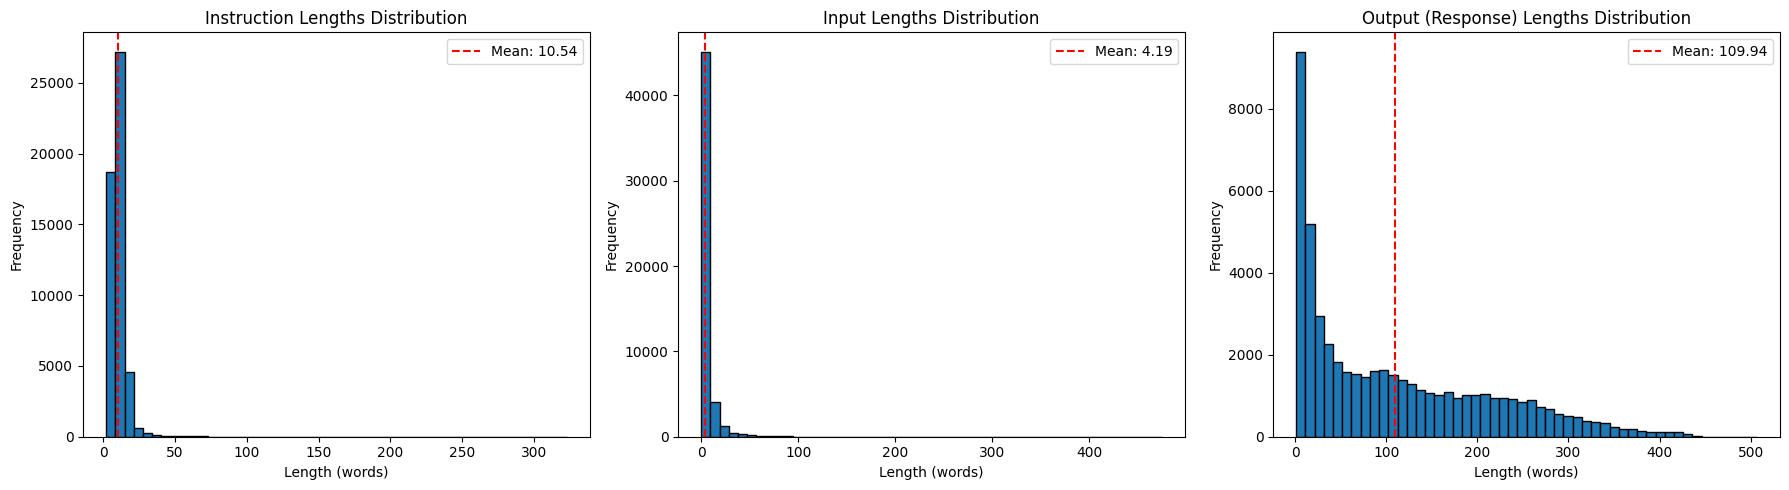

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Instruction lengths histogram
axes[0].hist(instruction_lengths, bins=50, edgecolor='black')
axes[0].set_title('Instruction Lengths Distribution')
axes[0].set_xlabel('Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(instruction_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(instruction_lengths):.2f}')
axes[0].legend()

# Input lengths histogram
axes[1].hist(input_lengths, bins=50, edgecolor='black')
axes[1].set_title('Input Lengths Distribution')
axes[1].set_xlabel('Length (words)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(input_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(input_lengths):.2f}')
axes[1].legend()

# Output lengths histogram
axes[2].hist(output_lengths, bins=50, edgecolor='black')
axes[2].set_title('Output (Response) Lengths Distribution')
axes[2].set_xlabel('Length (words)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(np.mean(output_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(output_lengths):.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

### 3.6 Create a Subset of 100 Examples

In [8]:
# Create a subset of 100 examples for efficient training
subset_dataset = dataset['train'].select(range(100))
print(f"Created subset with {len(subset_dataset)} examples")

# Save the subset for use in Milestone 2
subset_dataset.save_to_disk('../milestone2_finetuning/subset_data')
print("Subset saved to '../milestone2_finetuning/subset_data'")

Created subset with 100 examples


Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Subset saved to '../milestone2_finetuning/subset_data'


## 4. Model Setup

### 4.1 Load Qwen/Qwen3-0.6B-Base Model and Tokenizer

In [9]:
model_name = "Qwen/Qwen3-0.6B-Base"
print(f"Loading model: {model_name}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
print(f"✓ Tokenizer loaded successfully")
print(f"  Vocab size: {tokenizer.vocab_size}")
print(f"  Model max length: {tokenizer.model_max_length}")

# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device}")

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)

if not torch.cuda.is_available():
    model = model.to(device)

print(f"✓ Model loaded successfully")

Loading model: Qwen/Qwen3-0.6B-Base


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✓ Tokenizer loaded successfully
  Vocab size: 151643
  Model max length: 131072

Using device: cuda


config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

✓ Model loaded successfully


### 4.2 Determine Model Size and Memory Requirements

In [10]:
# Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Size Information:")
print(f"  Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"  Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")

# Estimate memory requirements
# For float32: 4 bytes per parameter
# For float16: 2 bytes per parameter
bytes_per_param = 2 if torch.cuda.is_available() else 4
memory_bytes = total_params * bytes_per_param
memory_gb = memory_bytes / (1024**3)

print(f"\nEstimated Memory Requirements:")
print(f"  Model weights: {memory_gb:.2f} GB")
print(f"  With activations and gradients: ~{memory_gb * 3:.2f} GB (approximate)")


Model Size Information:
  Total parameters: 596,049,920 (596.05M)
  Trainable parameters: 596,049,920 (596.05M)

Estimated Memory Requirements:
  Model weights: 1.11 GB
  With activations and gradients: ~3.33 GB (approximate)


### 4.3 Test Base Model Generation

In [11]:
# Test generation with base model
test_prompt = "What is the capital of France?"
print(f"\nTest Prompt: {test_prompt}")
print("\nGenerating response with base model...")

inputs = tokenizer(test_prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.7,
        do_sample=True,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"\nBase Model Response:\n{generated_text}")
print("\n✓ Base model generation test successful!")


Test Prompt: What is the capital of France?

Generating response with base model...

Base Model Response:
What is the capital of France? Which of the following is not a continent? What is the capital of India? Which of the following is not a capital of a state in India? Which of the following is not a capital of a state in India? Which of the following is not a capital of a state in India? Which of the following is not a capital of a state in India? Which of the following is not a capital of a state in India? Which of the following is not a capital of a state in India?

✓ Base model generation test successful!


## 5. Data Preprocessing

### 5.1 Format Examples with Alpaca Template

In [12]:
def format_alpaca_prompt(instruction, input_text, output):
    """
    Format the data according to the Alpaca prompt template.
    """
    if input_text:
        prompt = f"""Below is an instruction that describes a task, possibly with an input, that needs to be completed. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input_text}

### Response:
{output}"""
    else:
        prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Response:
{output}"""
    return prompt

# Test the formatting with a few examples
print("Formatted Example 1:")
print("=" * 80)
example = subset_dataset[0]
formatted = format_alpaca_prompt(example['instruction'], example['input'], example['output'])
print(formatted)
print("\n" + "=" * 80)

print("\nFormatted Example 2:")
print("=" * 80)
example = subset_dataset[1]
formatted = format_alpaca_prompt(example['instruction'], example['input'], example['output'])
print(formatted)
print("\n" + "=" * 80)

Formatted Example 1:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give three tips for staying healthy.

### Response:
1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.

2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.

3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.


Formatted Example 2:
Below is an instruction t

### 5.2 Tokenize Formatted Examples

In [13]:
# Tokenize a few examples to demonstrate
print("Tokenization Demo:")
print("=" * 80)

for i in range(3):
    example = subset_dataset[i]
    formatted_text = format_alpaca_prompt(
        example['instruction'],
        example['input'],
        example['output']
    )

    # Tokenize
    tokens = tokenizer(
        formatted_text,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    print(f"\nExample {i+1}:")
    print(f"  Original text length: {len(formatted_text)} characters")
    print(f"  Number of tokens: {tokens['input_ids'].shape[1]}")
    print(f"  Token IDs (first 20): {tokens['input_ids'][0][:20].tolist()}")

    # Decode to verify
    decoded = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)
    print(f"  Decoded matches original: {decoded[:100] == formatted_text[:100]}")

print("\n" + "=" * 80)
print("✓ Tokenization demonstration complete!")

Tokenization Demo:

Example 1:
  Original text length: 930 characters
  Number of tokens: 182
  Token IDs (first 20): [38214, 374, 458, 7600, 429, 16555, 264, 3383, 13, 9645, 264, 2033, 429, 34901, 44595, 279, 1681, 382, 14374, 29051]
  Decoded matches original: True

Example 2:
  Original text length: 483 characters
  Number of tokens: 94
  Token IDs (first 20): [38214, 374, 458, 7600, 429, 16555, 264, 3383, 13, 9645, 264, 2033, 429, 34901, 44595, 279, 1681, 382, 14374, 29051]
  Decoded matches original: True

Example 3:
  Original text length: 1373 characters
  Number of tokens: 278
  Token IDs (first 20): [38214, 374, 458, 7600, 429, 16555, 264, 3383, 13, 9645, 264, 2033, 429, 34901, 44595, 279, 1681, 382, 14374, 29051]
  Decoded matches original: True

✓ Tokenization demonstration complete!


### 5.3 Prepare Full Subset Dataset

In [14]:
def format_dataset(example):
    """Format the dataset with Alpaca template."""
    formatted_text = format_alpaca_prompt(
        example['instruction'],
        example['input'],
        example['output']
    )
    return {'text': formatted_text}

# Apply formatting to the entire subset
formatted_subset = subset_dataset.map(format_dataset)

print(f"✓ Formatted {len(formatted_subset)} examples")
print(f"\nDataset columns: {formatted_subset.column_names}")

# Save the formatted dataset
formatted_subset.save_to_disk('../milestone2_finetuning/formatted_subset_data')
print("✓ Formatted subset saved to '../milestone2_finetuning/formatted_subset_data'")

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

✓ Formatted 100 examples

Dataset columns: ['output', 'input', 'instruction', 'text']


Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

✓ Formatted subset saved to '../milestone2_finetuning/formatted_subset_data'
